<a href="https://colab.research.google.com/github/hmaldonado12/7506R-1C2024-GRUPO6/blob/main/7506R_TP1_GRUPO06_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import scipy.stats as st
import scipy.linalg as la
import sklearn as sk
import scipy.stats as st
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## **1. Análisis Exploratorio y Preprocesamiento de Datos**
El primer paso consiste en la selección de los datos que se van a utilizar, se deben filtrar
únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados
en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).
Se debe separar un conjunto de entrenamiento (80%) y un conjunto de test (20%).

#### **PREPRACION DE LOS DATOS**
Crear un nuevo dataset que contemplen los siguientes atributos :
- Tipos de vivienda: Casa, Ph Y Departamentos
- Moneda de transacción: Dólares (USD)
- Ubicacion : Capital Federal

##### **1.1 Mostrar informacion del dataset con los filtros requeridos del enunciado**

In [ ]:
properties_argentina = pd.read_csv('properati_argentina_2021.csv')

attributes_list = ["property_type", "operation", "property_currency", "place_l2"]
conditions_list = [["Casa", "PH","Departamento"],["Venta"],["USD"],["Capital Federal"]]

def get_dataframe_by(data, attributes: list, conditions: list):
    housing_type = data[attributes[0]].isin(conditions[0])
    is_operation_sale = data[attributes[1]].isin(conditions[1])
    is_property_currency_usd = data[attributes[2]].isin(conditions[2])
    is_place_l2_capital_federal = data[attributes[3]].isin(conditions[3])
    return data[housing_type & is_operation_sale & is_property_currency_usd & is_place_l2_capital_federal]

properties_argentina_filtered = get_dataframe_by(properties_argentina, attributes_list, conditions_list)
print("Dataframe antes de filtrar : ", properties_argentina.shape)
print("Datafrema filtrado: ", properties_argentina_filtered.shape)

Dataframe antes de filtrar :  (460154, 20)
Datafrema filtrado:  (94249, 20)


#### 1.2 Separar el conjunto de prueba y de entranamiento
- Entranamiento 80%
- Prueba 20 %

In [ ]:
properties_argentina_train_set, properties_argentina_test_set = train_test_split(properties_argentina_filtered, test_size=0.2, random_state=42)
print("Conjunto de Entranamiento: ", properties_argentina_train_set.shape)
print("Conjunto de Prueba: ", properties_argentina_test_set .shape)

Conjunto de Entranamiento:  (75399, 20)
Conjunto de Prueba:  (18850, 20)


Para el entrenamiento vamos a utilizar todos los datos, ya que tenemos un bug que aún no logramos resolver.

In [ ]:
properties_argentina_filtered = properties_argentina_train_set

## **ENTENDER EL PROBLEMA**
El objetivo del tp es poder entrenar un modelo que pueda predecir el valor de venta de un inmueble en cualquier barrio de capital federal.
En esta primera parte vamos a limpiar los datos y además entender como los datos pueden influir en la prediction de nuestro modelo o rendimiento de nuestro modelo.

### COMPROBACIONES PLANTEADAS EN EL TP
Las comprobaciones nos daran un entendimiento más profundo sobre los datos. Con los conocimientos de los datos vamos a tener más criterios para poder limpiar los mismos y poder entrenar el modelo.
#### a) Exploración Inicial: analizar cada variable, considerando los siguientes aspectos
#### a.1)Variables Cuantitativas: calcular medidas de resumen: media, mediana,moda,etc

In [ ]:
properties_argentina_filtered.describe()

,latitud,longitud,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
count,72420.000000,72420.000000,0.0,74555.000000,66597.000000,71509.000000,72708.000000,7.539900e+04
mean,-34.591358,-58.449737,NaN,2.825015,2.017208,111.841013,89.872806,2.260926e+05
std,0.188601,0.289167,NaN,1.433820,1.135236,1079.926643,1106.107524,3.183805e+05
min,-53.788624,-71.471192,NaN,1.000000,-1.000000,10.000000,1.000000,5.000000e+03
25%,-34.615996,-58.466550,NaN,2.000000,1.000000,45.000000,40.000000,9.500000e+04
50%,-34.595757,-58.439146,NaN,3.000000,2.000000,65.000000,58.000000,1.439000e+05
75%,-34.577367,-58.408917,NaN,4.000000,3.000000,105.000000,89.000000,2.380000e+05
max,-24.219827,-54.133330,NaN,40.000000,70.000000,137000.000000,217000.000000,2.140000e+07


#### a.2) Variables Cualitativas: mostrar cantidad de valores posibles, y frecuencias de cada uno.

In [ ]:
properties_argentina_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75399 entries, 285884 to 75496
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        75399 non-null  object 
 1   start_date                75399 non-null  object 
 2   end_date                  75399 non-null  object 
 3   created_on                75399 non-null  object 
 4   latitud                   72420 non-null  float64
 5   longitud                  72420 non-null  float64
 6   place_l2                  75399 non-null  object 
 7   place_l3                  75073 non-null  object 
 8   place_l4                  2870 non-null   object 
 9   place_l5                  0 non-null      object 
 10  place_l6                  0 non-null      float64
 11  operation                 75399 non-null  object 
 12  property_type             75399 non-null  object 
 13  property_rooms            74555 non-null  float64
 14  proper

Con la información del recuadro anterior vamos a agrupar las variables cualitativas

In [ ]:
attributes = ['place_l2', 'place_l3', 'place_l4', 'property_type', 'operation', 'property_currency', "property_title"]
properties_argentina_filtered[attributes].value_counts()

place_l2         place_l3  place_l4           property_type  operation  property_currency  property_title                                                              
Capital Federal  Palermo   Palermo Hollywood  Departamento   Venta      USD                Departamento - Palermo Hollywood                                                234
                           Palermo Chico      Departamento   Venta      USD                Departamento - Palermo Chico                                                    165
                           Palermo Soho       Departamento   Venta      USD                Departamento - Palermo Soho                                                     142
                           Palermo Hollywood  Departamento   Venta      USD                VENTA - Departamentos de 1, 2 y 3 amb  - Palermo Hollywood                       48
                           Palermo Viejo      Departamento   Venta      USD                Departamento - Palermo Viejo             

#### a.3) Determinar variables irrelevantes en el análisis
Con la información del punto anterior podemos determinar algunas variables que no son relevantes para nuestro modelo, es decir no nos van a aportar información de calidad que sirva para el entranamiento del modelo.

##### **Analisis :**
c.1) Los atributos start_date, end_date y create_on hacen referencia a las fechas en las cuales se crearon los datos, por lo tanto, esto no es relevante para nuestro modelo de predicción

c.2) Los atributos place_l3 y place_l4 son atributos relevantes, ya que el barrio puede influir en el precio de un inmueble.

Loss atributos place_l2, place_l5 y place_l6 los dejamos afuera del análisis. El atributo place_l2 lo utilizamos para filtrar la información por capital federal y los atributos place_l6,place_5 directamente no tiene datos.



Los atributos irrelevantes para nuestro análisis son :
- start_date
- end_date
- create_on
- place_l5
- place_l6

Por lo tanto, estas variables se pueden eliminar de la data frame

Podemos concluir que son atributos relevantes ya que el barrio puede influir en el precio de un inmueble.
Los valore irrelevantes para nuestro análisis son :
- start_date
- end_date
- create_on
- place_l5
- place_l6

Por lo tanto, estas variables se pueden eliminar de la data frame

In [ ]:
properties_argentina_filtered = properties_argentina_filtered.drop(columns=["start_date", "end_date", "created_on" ,"place_l5", "place_l6"])

#### a.4) Realizar un análisis gráfico de las distribuciones de las variables más relevantes

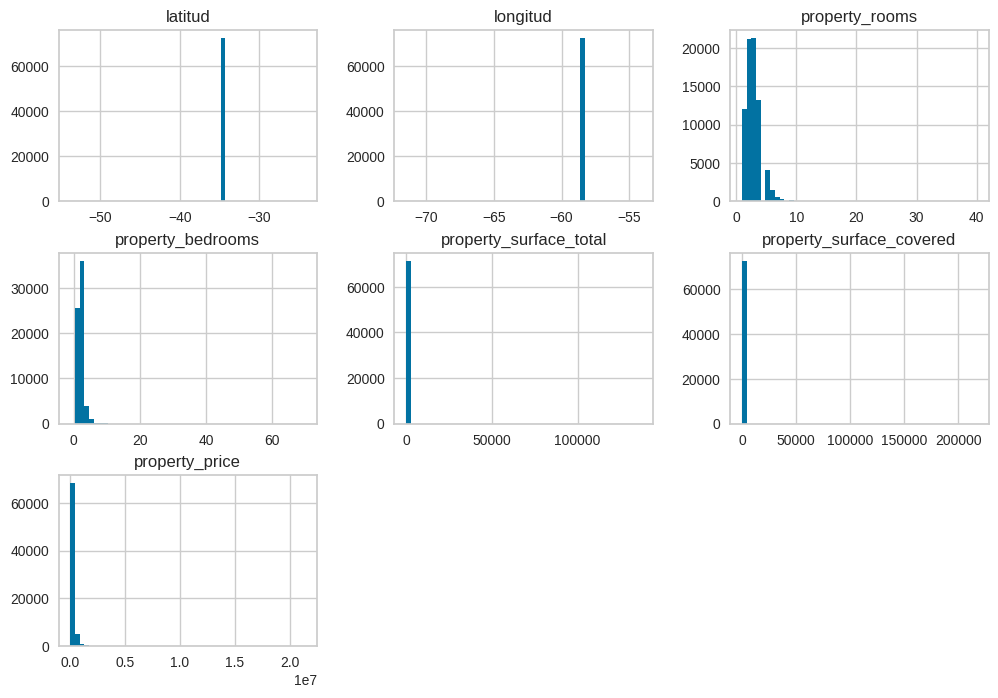

In [ ]:
properties_argentina_filtered.hist(figsize=(12, 8), bins=50)
plt.show()

#### a.5) Analizar las correlaciones existentes entre las variables.
Para analizar la correlación entre las variables, hay que seleccionar aquellas variables del tipo float64

<Axes: >

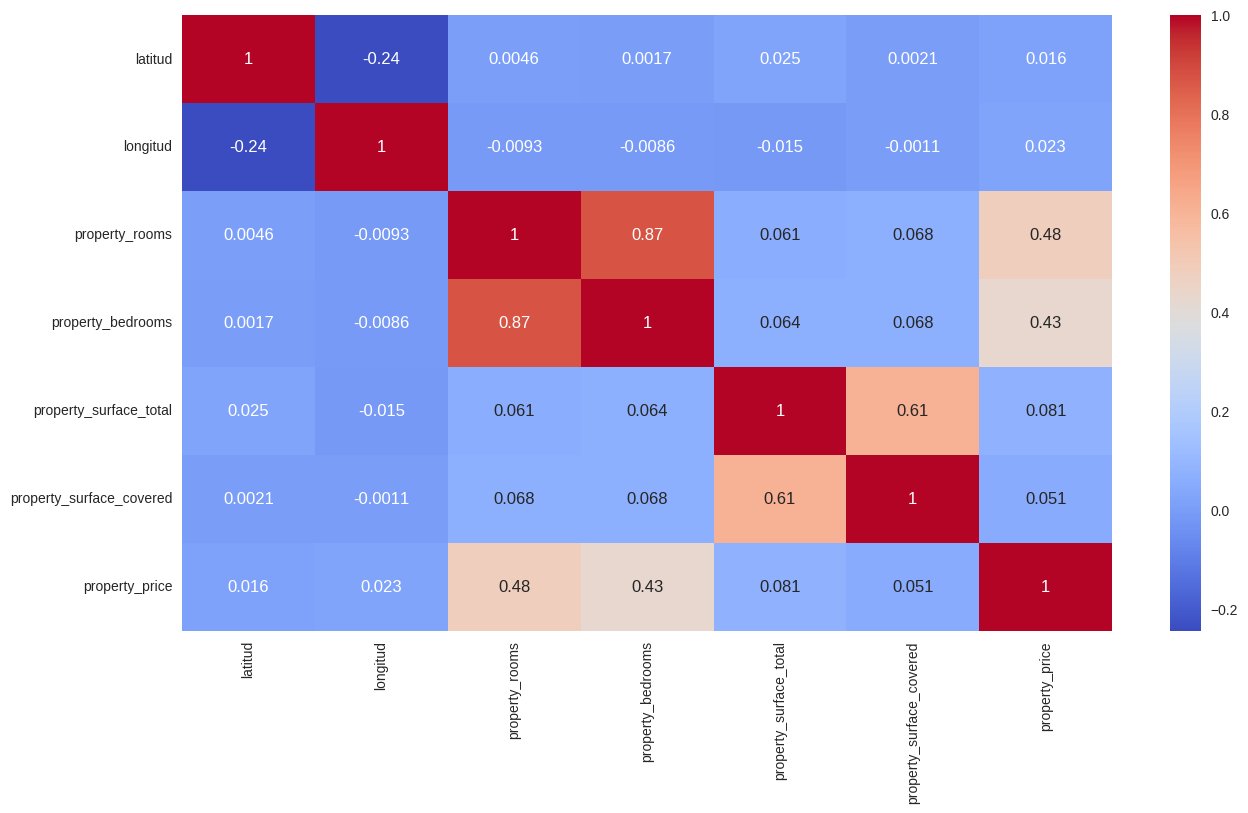

In [ ]:
properties_argentina_filtered_copy = properties_argentina_filtered.copy()
properties_argentina_numeric = properties_argentina_filtered_copy.select_dtypes(include=['float64', 'int64'])
corr_matrix = properties_argentina_numeric.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

Se analiza la correlación de todos los atributos respecto al precio de la propiedad, podemos observar que el atributo rooms y bedrooms tiene correlaciones positivas, esto quiere decir que el precio de una vivienda puede aumentar si estos dos atributos aumentan.

Con esta información también nos podemos preguntar lo siguiente: ¿La proporción de habitaciones/ambientes por casa puede influir en el precio de una propiedad?, para contestar esta pregunta, se puede crear una nueva variable que represente el nuevo atributo


In [ ]:
properties_argentina_filtered_copy = properties_argentina_filtered.copy()
properties_argentina_filtered_copy["property_bedrooms_ratio"] = properties_argentina_filtered_copy["property_bedrooms"] / properties_argentina_filtered_copy["property_rooms"]

properties_argentina_numeric = properties_argentina_filtered_copy.select_dtypes(include=['float64', 'int64'])
corr_matrix = properties_argentina_numeric.corr()
corr_property_price = corr_matrix["property_price"].sort_values(ascending=False)
print(corr_property_price)

property_price              1.000000
property_rooms              0.484365
property_bedrooms           0.426593
property_surface_total      0.080665
property_bedrooms_ratio     0.062126
property_surface_covered    0.050979
longitud                    0.022694
latitud                     0.016128
Name: property_price, dtype: float64


Si observamos el valor obtenido no tiene mucha influencia en sobre el valor de una propiedad.
También se puede hacer el mismo análisis con la proporción de la property_surface_covered/property_surface_total

In [ ]:
properties_argentina_filtered_copy = properties_argentina_filtered.copy()
properties_argentina_filtered_copy["property_surface_ratio"] = properties_argentina_filtered_copy["property_surface_covered"] / properties_argentina_filtered_copy["property_surface_total"]

properties_argentina_numeric = properties_argentina_filtered_copy.select_dtypes(include=['float64', 'int64'])
corr_matrix = properties_argentina_numeric.corr()
corr_property_price = corr_matrix["property_price"].sort_values(ascending=False)
print(corr_property_price)

property_price              1.000000
property_rooms              0.484365
property_bedrooms           0.426593
property_surface_total      0.080665
property_surface_covered    0.050979
longitud                    0.022694
latitud                     0.016128
property_surface_ratio     -0.001285
Name: property_price, dtype: float64


Si bien es una correlación negativa, el valor no es muy representativo, por lo tanto, podemos concluir que no influye en la determinación del precio de una propiedad.
Concluimos que los dos atributos que pueden influir en el precio de una propiedad son: property_bedrooms y property_rooms.

Esta es un conclusion muy temprano, ya que nos falta limpiar los datos, mas adelante vamos a tener una conclusion de las correlaciones un poco más coherente.

### b) Visualización de los datos: en esta sección se espera que puedan realizar una primera
Aproximación a los datos apoyándose en visualizaciones, por ejemplo: gráficos de dispersión
entre variables, histogramas, heatmaps, exploración de las columnas y cualquier otro gráfico
adicional que se considere útil justificando su utilización.
Para visualizar los datos, vamos a utilizar un gráfico del tipo geográfico. Est nos ayudará a entender en que zonas de capital los precios de las propiedades pueden ser más caras o más baratas.

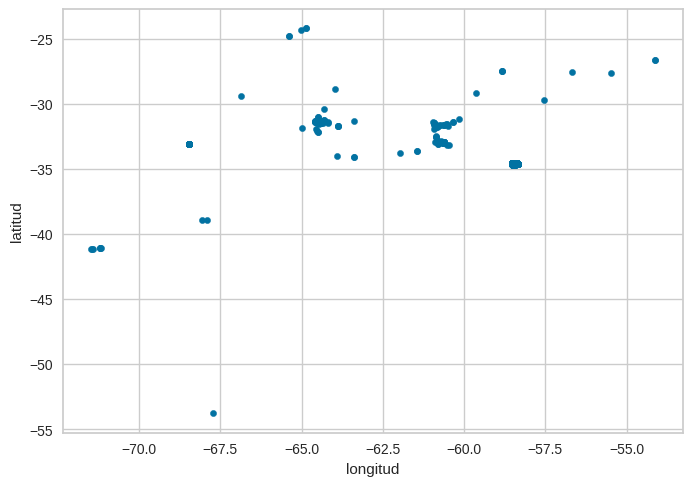

In [ ]:
properties_argentina_filtered.plot(kind="scatter", x="longitud", y="latitud", grid=True)
plt.show()

Otra cosa que podemos hacer es ver la densidad de puntos en el mapa

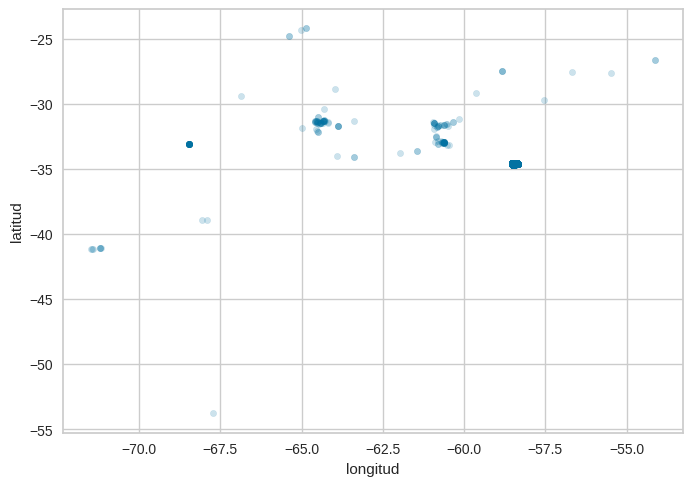

In [ ]:
properties_argentina_filtered.plot(kind="scatter", x="longitud", y="latitud", grid=True, alpha=0.2)
plt.show()

Ahora vamos a observar con un mapa de calor las propiedades mas caras y en que parte se concentran las que tiene más metros cuadrados(totales)

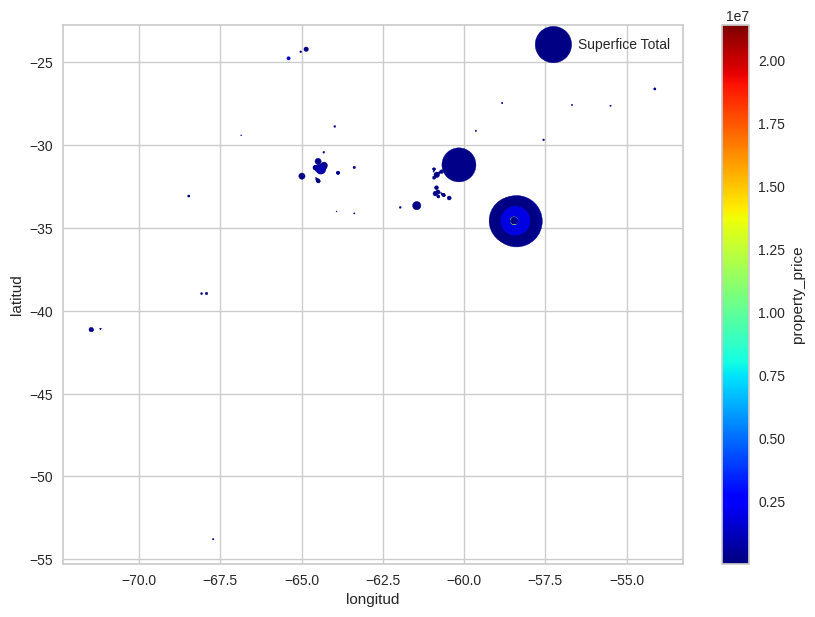

In [ ]:
properties_argentina_filtered.plot(kind="scatter", x="longitud", y="latitud", grid=True,
s=properties_argentina_filtered["property_surface_total"] / 100 , label="Superfice Total",
c="property_price", cmap="jet", colorbar=True,
legend=True, sharex=False, figsize=(10, 7))
plt.show()

#### Otros Gráficos que nos ayudara a entender a nivel de negocio como es el comportamiento de los inmuebles

#### b.2) Cantidad de Propiedades según El barrio

Text(0, 0.5, 'Cantidad de propiedades')

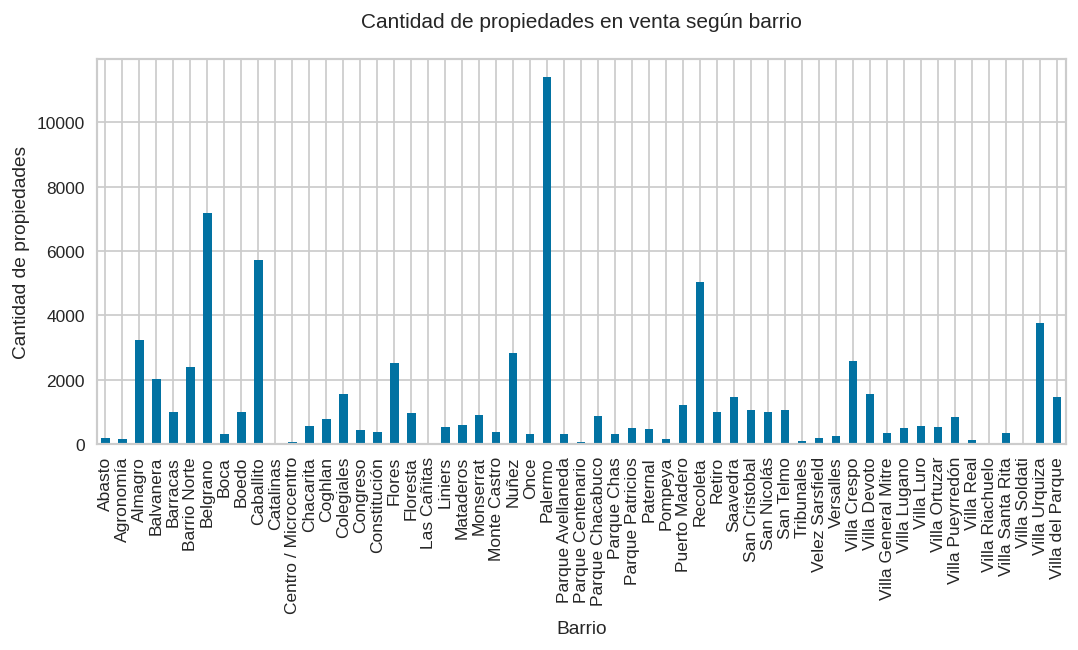

In [ ]:
plt.figure(dpi=125,figsize=(10,4))

properties_argentina_filtered.groupby('place_l3')['id'].count().plot(kind='bar')
plt.title("Cantidad de propiedades en venta según barrio\n")
plt.xlabel("Barrio")
plt.ylabel("Cantidad de propiedades")

#### b.3) Cantidad de inmuebles según el tipo

Text(0, 0.5, 'Cantidad de propiedades')

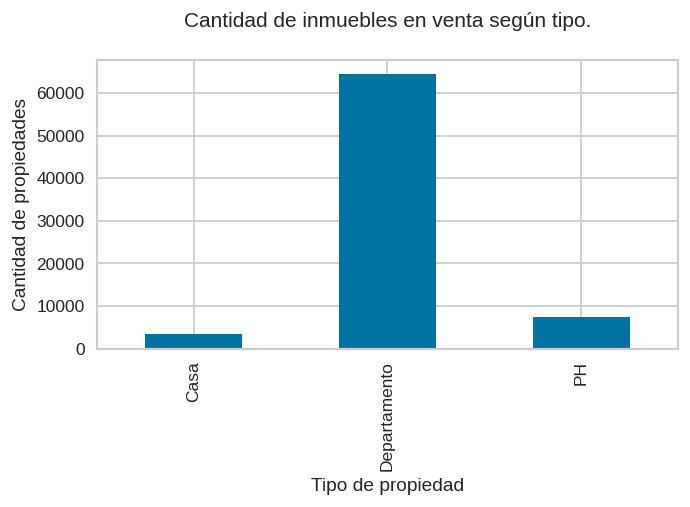

In [ ]:
plt.figure(dpi=125,figsize=(6,3))

properties_argentina_filtered.groupby('property_type')['id'].count().plot(kind='bar')
plt.title("Cantidad de inmuebles en venta según tipo.\n")
plt.xlabel("Tipo de propiedad")
plt.ylabel("Cantidad de propiedades")

#### c.) Datos Faltantes

* Realizar análisis de datos faltantes en columna. Graficar para cada variable el
porcentaje de datos faltantes con respecto al total del dataset.

Antes de empezar voy a llamar "" a la columna place_l3 y "" a la columna place_l2

In [ ]:
properties_argentina_filtered = properties_argentina_filtered.rename(columns={"place_l2":"city","place_l3":"zone"})

Primero busco caracteres raros como "NULL", "?", "-", como no hay ninguno sigo buscando valores faltantes:

In [ ]:
filas_totales = properties_argentina_filtered.shape[0]
porcentaje_col_faltante = properties_argentina_filtered.isna().sum() / filas_totales * 100
print(porcentaje_col_faltante)

id                           0.000000
latitud                      3.950981
longitud                     3.950981
city                         0.000000
zone                         0.432366
place_l4                    96.193583
operation                    0.000000
property_type                0.000000
property_rooms               1.119378
property_bedrooms           11.673895
property_surface_total       5.159220
property_surface_covered     3.569013
property_price               0.000000
property_currency            0.000000
property_title               0.000000
dtype: float64


Veo que todos los valores son bajos y no deberia dropear ninguna exceptuando a place_l4, como su funcion es especificar en que parte de Palermo estan algunas propiedades, lo mas lógico sería reemplazar a Palermo por la zona especifica en estas zonas y evitar tener una columna con más de un 96% de datos NaN.

In [ ]:
for i in range(1,properties_argentina_filtered.shape[0]):
    fila = properties_argentina_filtered.iloc[i]
    zona = fila["zone"]
    es_NaN = zona!=zona

    if not es_NaN and zona=="Palermo":
      zona_Palermo = fila["place_l4"]
      zona_Pal_NaN = zona_Palermo!=zona_Palermo
      if not zona_Pal_NaN:
        properties_argentina_filtered.iat[i, 4] = zona_Palermo

    i+=1

    properties_argentina_filtered=properties_argentina_filtered

::Ahora vamos a eliminar la columna place_l4 y luego volvemos a ver los datos faltantes por columna pero en un grafico:

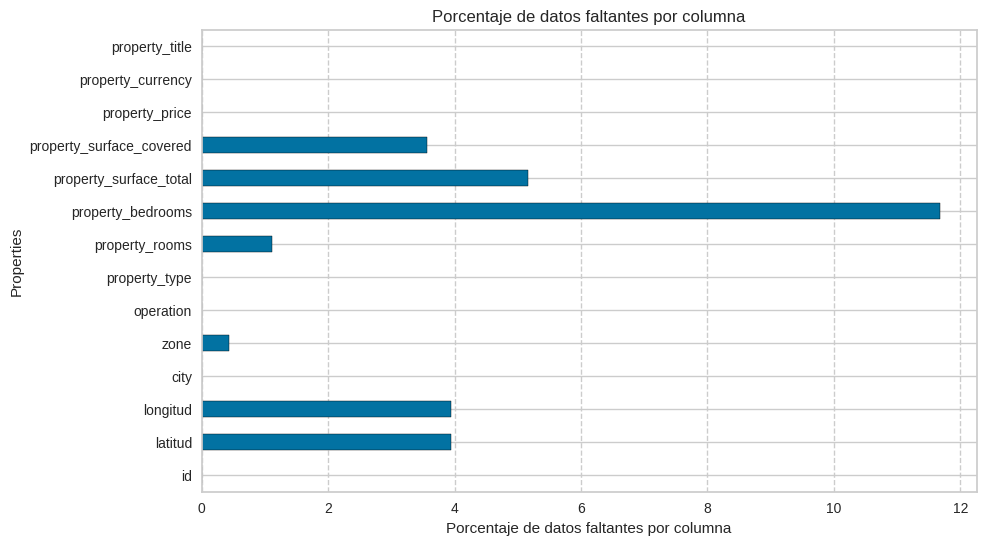

In [ ]:
properties_argentina_filtered = properties_argentina_filtered.drop(columns=["place_l4"])
filas_totales = properties_argentina_filtered.shape[0]
porcentaje_col_faltante = properties_argentina_filtered.isna().sum() / filas_totales * 100


porcentaje_col_faltante.plot(kind='barh', figsize=(10, 6), edgecolor='black')
plt.title('Porcentaje de datos faltantes por columna')
plt.ylabel('Properties')
plt.xlabel('Porcentaje de datos faltantes por columna')
plt.grid(axis='x', linestyle='--')
plt.show()

Podemos observar que exceptuando a "property_bedrooms" todas las columnas tienen un porcentaje de datos faltantes menor o similar al 5%.


*  Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de datos
faltantes de cada registro. Realizar un gráfico que permita conocer la proporción de
faltantes por fila en el dataset.



Primero calculo que porcentaje de cada fila falta:

*   Elemento de la lista

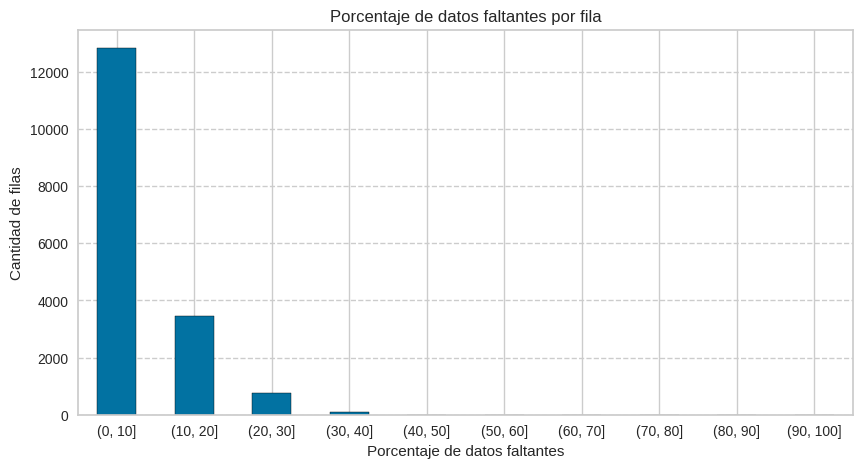

In [ ]:
col_totales = len(properties_argentina_filtered.columns)
porcentaje_faltante_fila = properties_argentina_filtered.isna().sum(axis=1) / col_totales * 100

rangos = [0,10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
porcentaje_agrupado = pd.cut(porcentaje_faltante_fila, bins=rangos).value_counts().sort_index()
plt.figure(figsize=(10, 5))
porcentaje_agrupado.plot(kind='bar', edgecolor='black')
plt.title('Porcentaje de datos faltantes por fila')
plt.xlabel('Porcentaje de datos faltantes')
plt.ylabel('Cantidad de filas')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

Se puede ver que las mayoría de las filas tienen entre un 0% y un 10% de datos faltantes, otros entre un 10% y un 20%, algunos pocos entre 20% y 30% y finalmente una porción muy menor entre el 30% y 40%.



*  Revisar los datos faltantes o mal ingresados y tomar una decisión sobre estos: reemplazo de
valores, eliminación de registros incompletos, etc.



**Primero** voy a asignarles la latitud y longitud a todas las filas que tengan una zona, les voy a asiganar la media de todos las filas de la misma zona.

In [ ]:
reparado = properties_argentina_filtered

place_l3_copy = properties_argentina_filtered["zone"]
place_l3_drop = place_l3_copy.drop_duplicates()
zones = place_l3_drop.values

media_zones = {}    #Me guardo las medias de (latitud,longitud) de c/zona

for zone in zones:
      zone_act = reparado[reparado["zone"]==zone]
      lat_med = zone_act["latitud"].mean()
      lon_med = zone_act["longitud"].mean()
      media_zones[zone] = (lat_med,lon_med)
      zone_act = zone_act.fillna({"latitud":lat_med,"longitud":lon_med})
      reparado[reparado["zone"]==zone]=zone_act


Ahora los únicas filas que no tienen latitud o longitud son los que tampoco tienen zona y esos los dropeamos ya que asignarle una zona basandonos en datos como precios y superficie total/cubierta podría alterar las mediciones que se quieran hacer en el futuro

In [ ]:
reparado.shape

(75399, 14)

Este es el número de filas antes de eliminar

In [ ]:
import math

i = 0
while i < reparado.shape[0]:
  fila = reparado.iloc[i]
  lat = fila["latitud"]
  if math.isnan(lat):
    reparado.drop(reparado.index[i:i+1], inplace=True)
  else:
    i+=1


reparado.shape

(75267, 14)

Este es el nuevo número de filas.

Ahora voy a asignarle un barrio a aquellas filas que no tienen pero si tienen latitud y longitud, para eso voy a calcular la distancia entre la ubicacion y la media de cada zona. Voy a calcular la diferencia entre la latitud y la longitud de cada fila y la media, luego calculo un promedio (diferencia de latitud sumado la diferencia de longitud dividido 2) y el barrio que menor diferencia tenga sera el elegido.

In [ ]:
for i in range(1,reparado.shape[0]):
    fila = reparado.iloc[i]
    zona = fila["zone"]
    bool = zona!=zona

    if bool:
      lat=fila["latitud"]
      lon=fila["longitud"]
      dist_menor = abs( abs(media_zones["Palermo"][0]) - abs(lat) ) + abs( abs( abs(media_zones["Palermo"][1] ) - abs(lon) ))
      barrio = "Palermo"

      # print("ARRANCA CON PALERMO:","lat:",lat,"lon:",lon)
      for c in media_zones:

          tupla_dist = media_zones.get(c)
          nueva_dist = abs( abs(tupla_dist[0]) - abs(lat) ) + abs( abs( abs(tupla_dist[1] ) - abs(lon) ))
          es_menor = nueva_dist<dist_menor

          if es_menor:
            dist_menor=nueva_dist
            barrio = c

      # reparado.iloc[i]["zone"] = barrio
      reparado.iat[i, 4] = barrio


    i+=1

reparado = reparado


Vemos que no hay ningun NaN restante en la columna zone:

In [ ]:
reparado["zone"].isna().value_counts()

zone
False    75267
Name: count, dtype: int64

Ahora vamos a completar la columna "property_surface_total" la cual se podría calcular teniendo en cuenta el precio medio por m2 de cada zona.

In [ ]:
prec_m2 = {}

for zona in zones:
  zona_act = reparado[reparado["zone"]==zona]
  prec_tot = 0
  sup_tot = 0

  for i in range(0,zona_act.shape[0]):
    fila = zona_act.iloc[i]
    prec = fila["property_price"]
    sup = fila["property_surface_total"]

    if not sup!=sup:    #es decir si la columna property_surface_total no es NaN
      prec_tot+=prec
      sup_tot+=sup

  if sup_tot!=0:
    prec_prom = prec_tot/sup_tot

    prec_m2[zona]= prec_prom





Ahora que ya sabemos los precios del m2 podriamos hacer una regla de 3 y sabiendo el precio de la propiedad obtener un estimado realista de la superficie total de esta.

In [ ]:
for i in range (0,reparado.shape[0]):
  fila = reparado.iloc[i]
  zona = fila["zone"]
  sup = fila["property_surface_total"]
  if sup!=sup:
      prec = fila["property_price"]
      sup_calc = prec/prec_m2.get(zona)
      reparado.iat[i, 9] = sup_calc


Ahora buscamos el porcentaje de superficie cubierta por zona, este sera un porcentaje de la superficie total y sera: (sup_cub * 100)/sup_tot.
Ahora calculamos ese porcentaje por zona:

In [ ]:
porc_sup_cub = {}

for zona in zones:
  zona_act = reparado[reparado["zone"]==zona]
  sup_tot = 0
  sup_cub = 0

  for i in range(0,zona_act.shape[0]):
    fila = zona_act.iloc[i]
    s_tot = fila["property_surface_total"]
    s_cub = fila["property_surface_covered"]

    if not s_cub!=s_cub:    #es decir si la columna property_surface_covered no es NaN
      sup_tot+=s_tot
      sup_cub+=s_cub

  if sup_tot!=0:
    porc_cub = (sup_cub * 100)/sup_tot
    porc_sup_cub[zona]= porc_cub

Ahora que ya sabemos los porcentajes de superficie cubierta con respecto a la superficie total hay que imputar la superficie cubierta de aquellas filas que no posean ese dato:

In [ ]:
for i in range (0,reparado.shape[0]):
  fila = reparado.iloc[i]
  zona = fila["zone"]
  sup_cub = fila["property_surface_covered"]
  if sup_cub!=sup_cub:
      sup_tot = fila["property_surface_total"]
      nueva_sup_cub = sup_tot * porc_sup_cub.get(zona)
      reparado.iat[i, 10] = nueva_sup_cub

Ahora voy a calcular el promedio de superficie cubierta por habitación que hay en cada zona para luego poder estimar cuantas habitaciones (rooms) tiene cada propiedades a las que le falte el dato.

In [ ]:
met_por_hab = {}

for zona in zones:
  zona_act = reparado[reparado["zone"]==zona]
  r_mediana = zona_act["property_rooms"].median()
  s_mediana = zona_act["property_surface_total"].median()
  met_por_hab[zona]=s_mediana/r_mediana


Teniendo el promedio de metros por habitación de cada zona, calculo e imputo los datos de property_rooms faltantes

In [ ]:
for i in range (0,reparado.shape[0]):
  fila = reparado.iloc[i]
  zona = fila["zone"]
  rooms = fila["property_rooms"]
  if rooms!=rooms:
      sup_cub = fila["property_surface_covered"]
      nuevo_rooms = sup_cub / met_por_hab.get(zona)
      reparado.iat[i, 7] = round(nuevo_rooms)

Finalmente solo queda completar la columna property_beedrooms, para la cual primero calcularemos por zona el porcentaje de rooms que son bedrooms, esto para luego poder estimar cuantos bedrooms hay utilizando el dato property_rooms

In [ ]:
por_bedrooms = {}

rooms=reparado["property_rooms"].median()
bedrooms=reparado["property_bedrooms"].median()
porcentaje_mediana_gral = (bedrooms*100)/rooms


for zona in zones:
  zona_act = reparado[reparado["zone"]==zona]
  r_mediana = zona_act["property_rooms"].median()
  b_mediana = zona_act["property_bedrooms"].median()
  porcentaje = (b_mediana * 100)/r_mediana
  if porcentaje==100.0:
    porcentaje=porcentaje_mediana_gral
  por_bedrooms[zona] = porcentaje


Ahora queda imputar el dato en aquillas filas donde no esta:

In [ ]:
for i in range (0,reparado.shape[0]):
  fila = reparado.iloc[i]
  zona = fila["zone"]
  bedrooms = fila["property_bedrooms"]
  if bedrooms!=bedrooms:
      rooms = fila["property_rooms"]
      calc_bedrooms = (rooms*por_bedrooms.get(zona)/100)
      reparado.iat[i, 8] = round(calc_bedrooms)

Podemos ver que ya no hay datos faltantes:

In [ ]:
reparado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75267 entries, 285884 to 75496
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        75267 non-null  object 
 1   latitud                   75267 non-null  float64
 2   longitud                  75267 non-null  float64
 3   city                      75267 non-null  object 
 4   zone                      75267 non-null  object 
 5   operation                 75267 non-null  object 
 6   property_type             75267 non-null  object 
 7   property_rooms            75267 non-null  float64
 8   property_bedrooms         75267 non-null  float64
 9   property_surface_total    75267 non-null  float64
 10  property_surface_covered  75267 non-null  float64
 11  property_price            75267 non-null  float64
 12  property_currency         75267 non-null  object 
 13  property_title            75267 non-null  object 
dtypes: flo

Finalmente se podrían quitar las columnas "property_currency" ya que todas estan en USD y la columna "id" ya que todos los id son únicos y no aportan informacion

In [ ]:
reparado = reparado.drop(columns=["id", "property_currency"])

Y ahora la estructura es la siguiente:

In [ ]:
reparado.head(1)

,latitud,longitud,city,zone,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
285884,-34.62139,-58.506366,Capital Federal,Monte Castro,Venta,Departamento,3.0,2.0,51.0,44.0,112000.0,Venta tres ambientes chico cochera y amplio ba...


#### d.) Análisis de valores atípicos.

Primero comenzamos buscando valores que no sean lógicos del problema a tratar.

In [ ]:
reparado[(reparado['property_bedrooms'] < 0) | (reparado['property_rooms'] < 0)]

,latitud,longitud,city,zone,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
406880,-34.577595,-58.495185,Capital Federal,Villa Urquiza,Venta,Departamento,2.0,-1.0,61.0,43.0,125000.0,Jardines de Roosevelt - Hermoso 3 ambientes co...


No es probable que un inmueble, en este caso un departamento, -1 habitaciones. Puede tratarse de un dato mal cargado o de un registro incorrecto. Consideraremos que se trata de un error de tipeo por el título del anuncio haciendo referencia que se trata de un tres ambientes

In [ ]:
reparado.loc[reparado[reparado['property_bedrooms'] < 0].index,'property_bedrooms'] = 1

Realizamos los mismos para otras variables y no nos encontramos registros que cumplan con la condición.

In [ ]:
reparado[(reparado['property_price'] <= 0) | (reparado['property_surface_total'] <= 0) | (reparado['property_surface_covered'] <= 0)]

,latitud,longitud,city,zone,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title


#### d.2) Análisis univariado

Para encontrar otros valores atípicos comenzaremos con un análisis univariado. Decidimos comenzar graficando diferentes boxplot para poder reconocer los valores que se alejan de manera visual y así tener un primer acercamiento.

In [ ]:
columnas = ['property_rooms', 'property_bedrooms']

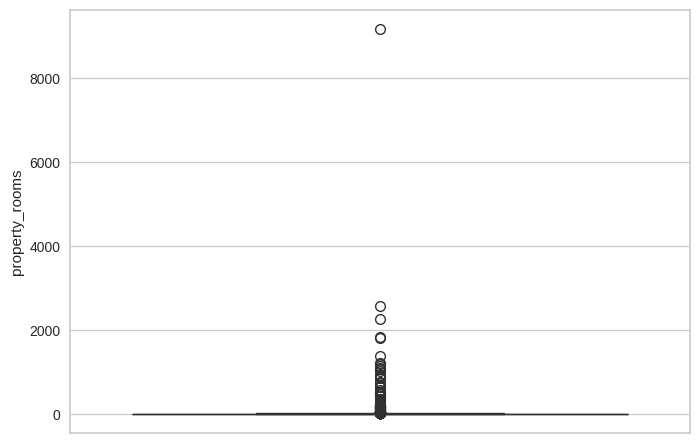

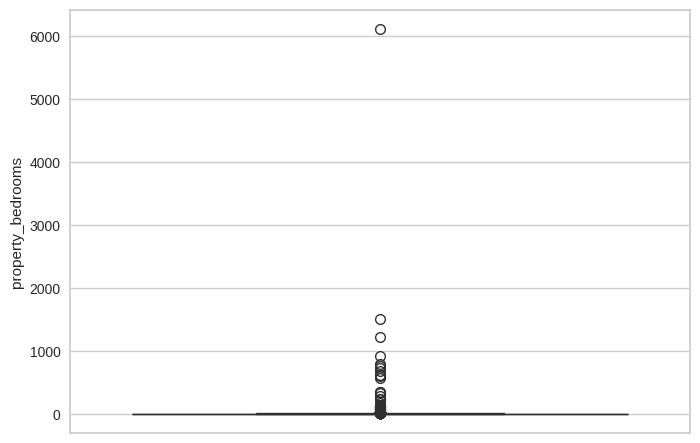

In [ ]:
for col in columnas:
  sns.boxplot(y=reparado[col])
  plt.show()
  print('\n\n')

Podemos notar que tenemos registros que se alejan del común de los datos. Se puede ver a simple vista que son outliers

#### property_bedrooms

In [ ]:
reparado['property_bedrooms'].describe()

count    75267.000000
mean         2.156124
std         24.736009
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max       6113.000000
Name: property_bedrooms, dtype: float64

Calcularemos la métrica Z-score y Z-score modificado para luego tomar decisiones al respecto.

In [ ]:
def z_calculation(serie):
  media = np.mean(serie)
  std = np.std(serie)
  return (serie - media) / std

def z_mod_calculation(serie):
  median = np.median(serie)
  MAD = np.median(np.absolute(serie - median))
  return (serie - median) * 0.6745 / MAD

In [ ]:
reparado["z_bedrooms"] = z_calculation(reparado['property_bedrooms'])

In [ ]:
reparado["z_mod_bedrooms"] = z_mod_calculation(reparado['property_bedrooms'])

Observaremos los inmuebles que cumplen con la "regla de oro" de ambas métricas.

In [ ]:
print(reparado[(reparado['z_bedrooms'] > 3) | (reparado['z_bedrooms'] < -3)].shape)
reparado[(reparado['z_bedrooms'] > 3) | (reparado['z_bedrooms'] < -3)]

(34, 14)


,latitud,longitud,city,zone,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_bedrooms,z_mod_bedrooms
333910,-34.651286,-58.508025,Capital Federal,Liniers,Venta,Departamento,2257.0,1505.0,595.000000,47402.815840,1100000.0,Departamento - Liniers,60.755713,1013.7735
21244,-34.625605,-58.397219,Capital Federal,Constitución,Venta,Casa,1182.0,788.0,318.000000,28365.840806,300000.0,Casa - Constitución,31.769438,530.1570
169009,-34.628589,-58.463167,Capital Federal,Flores,Venta,PH,184.0,123.0,50.000000,4223.766954,10000.0,Tus Contactos Valen Recomendanos Gente y Gana ...,4.885375,81.6145
4275,-34.638494,-58.468998,Capital Federal,Flores,Venta,Casa,856.0,571.0,233.000000,19682.754007,249900.0,Casa - Flores,22.996743,383.7905
375559,-34.558574,-58.446057,Capital Federal,Belgrano,Venta,Departamento,123.0,82.0,37.000000,3150.932253,117000.0,Departamento - Belgrano,3.227861,53.9600
403550,-34.631721,-58.478355,Capital Federal,Floresta,Venta,PH,1101.0,734.0,313.000000,24587.791974,260000.0,Venta en Block - 4 PH a refaccionar en Floresta,29.586371,493.7340
209150,-34.597522,-58.374412,Capital Federal,Retiro,Venta,Departamento,128.0,85.0,31.000000,2891.578103,80000.0,Departamento - Retiro,3.349143,55.9835
32624,-34.641866,-58.402643,Capital Federal,Parque Patricios,Venta,Casa,523.0,349.0,127.000000,10984.530487,225000.0,Casa - Parque Patricios,14.021914,234.0515
169752,-34.628589,-58.463167,Capital Federal,Flores,Venta,Departamento,184.0,123.0,50.000000,4223.766954,10000.0,Tus Contactos Valen Recomendanos Gente y Gana ...,4.885375,81.6145
24893,-34.603877,-58.493163,Capital Federal,Villa del Parque,Venta,PH,341.0,227.0,95.000000,7607.117198,230000.0,PH 4 ambientes terraza y patio - Villa del Parque,9.089800,151.7625


In [ ]:
print(reparado[(reparado['z_mod_bedrooms'] > 3.5) | (reparado['z_mod_bedrooms'] < -3.5)].shape)
reparado[(reparado['z_mod_bedrooms'] > 3.5) | (reparado['z_mod_bedrooms'] < -3.5)]

(216, 14)


,latitud,longitud,city,zone,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_bedrooms,z_mod_bedrooms
328872,-34.583469,-58.450238,Capital Federal,Chacarita,Venta,Casa,13.0,9.0,530.000000,360.0,560000.0,Casa - Chacarita,0.276678,4.7215
129078,-34.597318,-58.389639,Capital Federal,Recoleta,Venta,Departamento,9.0,8.0,160.000000,160.0,315000.0,Piso 8 dormitorios en venta - Recoleta - Marce...,0.236251,4.0470
147972,-34.605473,-58.387790,Capital Federal,San Nicolás,Venta,Departamento,9.0,8.0,180.000000,156.0,175000.0,Departamento - San Nicolas,0.236251,4.0470
396876,-34.604062,-58.405112,Capital Federal,Once,Venta,Departamento,14.0,12.0,301.000000,179.0,220000.0,Venta Departamento 12 Ambientes,0.397960,6.7450
212637,-34.559873,-58.449254,Capital Federal,Belgrano,Venta,Departamento,12.0,8.0,470.000000,300.0,1150000.0,Local - Belgrano Barrancas,0.236251,4.0470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33028,-34.642399,-58.445755,Capital Federal,Flores,Venta,Casa,9.0,8.0,375.000000,350.0,250000.0,CASA TALLER DEPOSITO VENTA BAJO FLORES,0.236251,4.0470
309970,-34.617148,-58.463260,Capital Federal,Flores,Venta,Departamento,17.0,11.0,547.000000,396.0,1100000.0,EDIFICIO EN BLOQUE A ESTRENAR - 8 UNIDADES - 1...,0.357533,6.0705
312668,-34.655732,-58.409439,Capital Federal,Pompeya,Venta,PH,14.0,10.0,270.000000,217.0,190000.0,PH 5 DEPARTAMENTOS OPORTUNIDAD VENTA POMPEYA ...,0.317106,5.3960
94998,-34.646632,-58.497902,Capital Federal,Villa Luro,Venta,Departamento,3.0,70.0,82.745773,70.0,135000.0,Departamento - Villa Luro,2.742735,45.8660


In [ ]:
print(reparado[((reparado['z_mod_bedrooms'] > 3.5) | (reparado['z_mod_bedrooms'] < -3.5)) & ((reparado['z_bedrooms'] > 3) | (reparado['z_bedrooms'] < -3))].shape)
reparado[((reparado['z_mod_bedrooms'] > 3.5) | (reparado['z_mod_bedrooms'] < -3.5)) & ((reparado['z_bedrooms'] > 3) | (reparado['z_bedrooms'] < -3))]

(34, 14)


,latitud,longitud,city,zone,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_bedrooms,z_mod_bedrooms
333910,-34.651286,-58.508025,Capital Federal,Liniers,Venta,Departamento,2257.0,1505.0,595.000000,47402.815840,1100000.0,Departamento - Liniers,60.755713,1013.7735
21244,-34.625605,-58.397219,Capital Federal,Constitución,Venta,Casa,1182.0,788.0,318.000000,28365.840806,300000.0,Casa - Constitución,31.769438,530.1570
169009,-34.628589,-58.463167,Capital Federal,Flores,Venta,PH,184.0,123.0,50.000000,4223.766954,10000.0,Tus Contactos Valen Recomendanos Gente y Gana ...,4.885375,81.6145
4275,-34.638494,-58.468998,Capital Federal,Flores,Venta,Casa,856.0,571.0,233.000000,19682.754007,249900.0,Casa - Flores,22.996743,383.7905
375559,-34.558574,-58.446057,Capital Federal,Belgrano,Venta,Departamento,123.0,82.0,37.000000,3150.932253,117000.0,Departamento - Belgrano,3.227861,53.9600
403550,-34.631721,-58.478355,Capital Federal,Floresta,Venta,PH,1101.0,734.0,313.000000,24587.791974,260000.0,Venta en Block - 4 PH a refaccionar en Floresta,29.586371,493.7340
209150,-34.597522,-58.374412,Capital Federal,Retiro,Venta,Departamento,128.0,85.0,31.000000,2891.578103,80000.0,Departamento - Retiro,3.349143,55.9835
32624,-34.641866,-58.402643,Capital Federal,Parque Patricios,Venta,Casa,523.0,349.0,127.000000,10984.530487,225000.0,Casa - Parque Patricios,14.021914,234.0515
169752,-34.628589,-58.463167,Capital Federal,Flores,Venta,Departamento,184.0,123.0,50.000000,4223.766954,10000.0,Tus Contactos Valen Recomendanos Gente y Gana ...,4.885375,81.6145
24893,-34.603877,-58.493163,Capital Federal,Villa del Parque,Venta,PH,341.0,227.0,95.000000,7607.117198,230000.0,PH 4 ambientes terraza y patio - Villa del Parque,9.089800,151.7625


In [ ]:
reparado[((reparado['z_mod_bedrooms'] > 3.5) | (reparado['z_mod_bedrooms'] < -3.5)) & ((reparado['z_bedrooms'] > 3) | (reparado['z_bedrooms'] < -3))]['property_bedrooms'].describe()

count      34.000000
mean      534.441176
std      1048.550376
min        78.000000
25%       110.250000
50%       198.000000
75%       609.750000
max      6113.000000
Name: property_bedrooms, dtype: float64

Podemos ver que este rango se centra en inmuebles con más de 75 bedrooms. Decidimos eliminar las filas de los registros con estos valores porque no pudimos encontrarle una razón lógica a los datos y resultaban estar muy alejados a la realidad y que, al final, a la hora de entrenar un modelo para obtener la predicción que buscamos va a causar resultados erróneos.

In [ ]:
index = reparado[((reparado['z_mod_bedrooms'] > 3.5) | (reparado['z_mod_bedrooms'] < -3.5)) & ((reparado['z_bedrooms'] > 3) | (reparado['z_bedrooms'] < -3))].index
reparado.drop(index, inplace=True)

In [ ]:
reparado[(reparado['z_bedrooms'] > 3) | (reparado['z_bedrooms'] < -3)]

,latitud,longitud,city,zone,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_bedrooms,z_mod_bedrooms


In [ ]:
reparado[(reparado['z_mod_bedrooms'] > 3.5) | (reparado['z_mod_bedrooms'] < -3.5)]

,latitud,longitud,city,zone,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_bedrooms,z_mod_bedrooms
328872,-34.583469,-58.450238,Capital Federal,Chacarita,Venta,Casa,13.0,9.0,530.000000,360.0,560000.0,Casa - Chacarita,0.276678,4.7215
129078,-34.597318,-58.389639,Capital Federal,Recoleta,Venta,Departamento,9.0,8.0,160.000000,160.0,315000.0,Piso 8 dormitorios en venta - Recoleta - Marce...,0.236251,4.0470
147972,-34.605473,-58.387790,Capital Federal,San Nicolás,Venta,Departamento,9.0,8.0,180.000000,156.0,175000.0,Departamento - San Nicolas,0.236251,4.0470
396876,-34.604062,-58.405112,Capital Federal,Once,Venta,Departamento,14.0,12.0,301.000000,179.0,220000.0,Venta Departamento 12 Ambientes,0.397960,6.7450
212637,-34.559873,-58.449254,Capital Federal,Belgrano,Venta,Departamento,12.0,8.0,470.000000,300.0,1150000.0,Local - Belgrano Barrancas,0.236251,4.0470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33028,-34.642399,-58.445755,Capital Federal,Flores,Venta,Casa,9.0,8.0,375.000000,350.0,250000.0,CASA TALLER DEPOSITO VENTA BAJO FLORES,0.236251,4.0470
309970,-34.617148,-58.463260,Capital Federal,Flores,Venta,Departamento,17.0,11.0,547.000000,396.0,1100000.0,EDIFICIO EN BLOQUE A ESTRENAR - 8 UNIDADES - 1...,0.357533,6.0705
312668,-34.655732,-58.409439,Capital Federal,Pompeya,Venta,PH,14.0,10.0,270.000000,217.0,190000.0,PH 5 DEPARTAMENTOS OPORTUNIDAD VENTA POMPEYA ...,0.317106,5.3960
94998,-34.646632,-58.497902,Capital Federal,Villa Luro,Venta,Departamento,3.0,70.0,82.745773,70.0,135000.0,Departamento - Villa Luro,2.742735,45.8660


In [ ]:
reparado[((reparado['z_mod_bedrooms'] > 3.5) | (reparado['z_mod_bedrooms'] < -3.5))]['property_bedrooms'].describe()

count    182.000000
mean      14.280220
std       12.461811
min        8.000000
25%        8.000000
50%       10.000000
75%       14.750000
max       76.000000
Name: property_bedrooms, dtype: float64

Existen registros que cumplen con la regla de oro del z-score modificado, pero que coinciden con la descripción de la publicación y no resultan tan alejados a la realidad como para decidir eliminarlos.

#### property_rooms

In [ ]:
reparado['property_rooms'].describe()

count    75233.000000
mean         3.115893
std         16.201402
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max       2558.000000
Name: property_rooms, dtype: float64

Apreciamos que también tenemos un valor altísimo de ambientes que no resultan lógicos, volveremos a analizar con más detenimiento estos casos y calcularemos las métricas.

<Axes: ylabel='property_rooms'>

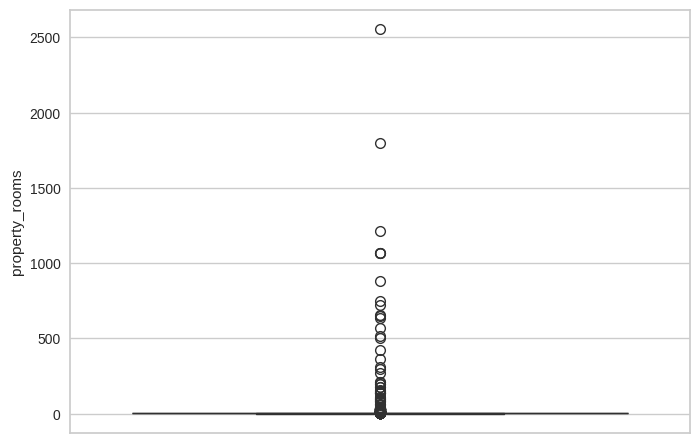

In [ ]:
sns.boxplot(y=reparado['property_rooms'])

In [ ]:
reparado["z_rooms"] = z_calculation(reparado['property_rooms'])
reparado["z_mod_rooms"] = z_mod_calculation(reparado['property_rooms'])

43 filas del dataset cumplen con la regla de oro del z-score

In [ ]:
reparado[(reparado['z_rooms'] > 3) | (reparado['z_rooms'] < -3)].shape

(43, 16)

Mientras que 530 filas con el z-score modificado.

In [ ]:
reparado[(reparado['z_mod_rooms'] > 3.5) | (reparado['z_mod_rooms'] < -3.5)].shape

(530, 16)

Al igual que antes, decidimos observar los registros que cumplen con ambos antes.

In [ ]:
print(reparado[((reparado['z_rooms'] > 3) | (reparado['z_rooms'] < -3)) & ((reparado['z_mod_rooms'] > 3.5) | (reparado['z_mod_rooms'] < -3.5))].shape)
reparado[((reparado['z_rooms'] > 3) | (reparado['z_rooms'] < -3)) & ((reparado['z_mod_rooms'] > 3.5) | (reparado['z_mod_rooms'] < -3.5))]

(43, 16)


,latitud,longitud,city,zone,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_bedrooms,z_mod_bedrooms,z_rooms,z_mod_rooms
356600,-34.582228,-58.406415,Capital Federal,Palermo,Venta,Departamento,106.0,71.0,35.00000,2332.305083,130000.0,Departamento - Palermo,2.783163,46.5405,6.350363,69.4735
192561,-34.623793,-58.402256,Capital Federal,San Cristobal,Venta,Casa,1801.0,13.0,368.00000,32442.736120,350000.0,"Casa con 6 dptos tipo ph en BLOCK, IDEAL PARA ...",0.438387,7.4195,110.971632,1212.7510
161979,-34.593729,-58.379936,Capital Federal,Retiro,Venta,Departamento,502.0,2.0,122.00000,11379.758984,370000.0,Departamento - Retiro,-0.006312,0.0000,30.792854,336.5755
434544,-34.620429,-58.361087,Capital Federal,Puerto Madero,Venta,Departamento,298.0,2.0,127.00000,11726.095681,720000.0,Departamento - Puerto Madero,-0.006312,0.0000,18.201268,198.9775
105126,-34.576741,-58.404830,Capital Federal,Palermo Chico,Venta,Departamento,1070.0,4.0,400.00000,36631.173435,2700000.0,Departamento - Palermo Chico,0.074543,1.3490,65.851781,719.6915
248089,-34.575048,-58.420743,Capital Federal,Palermo,Venta,Departamento,1212.0,4.0,400.00000,26654.915239,2700000.0,Departamento - Palermo Nuevo,0.074543,1.3490,74.616512,815.4705
306004,-34.628711,-58.458227,Capital Federal,Flores,Venta,Departamento,268.0,2.0,73.00000,6166.699753,149000.0,VENTA - 3 AMBIENTES - 2 DORMITORIOS EN SUITE ...,-0.006312,0.0000,16.349564,178.7425
2790,-34.606366,-58.383480,Capital Federal,San Nicolás,Venta,Departamento,750.0,6.0,178.00000,16882.888903,200000.0,"venta DEPARTAMENTO APTO PROFESIONAL, 6 habitac...",0.155397,2.6980,46.100273,503.8515
60841,-34.609896,-58.476014,Capital Federal,Paternal,Venta,PH,647.0,4.0,165.00000,12949.243616,109000.0,PH - Paternal,0.074543,1.3490,39.742756,434.3780
389059,-34.577332,-58.445887,Capital Federal,Colegiales,Venta,PH,57.0,38.0,37.00000,1242.091576,115000.0,PH - Colegiales,1.449066,24.2820,3.325914,36.4230


In [ ]:
reparado['property_rooms'].describe()

count    75233.000000
mean         3.115893
std         16.201402
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max       2558.000000
Name: property_rooms, dtype: float64

También resultan valores bastante alejados de la realidad que, si los dejamos, puede que entrene en un futuro a nuestro modelo de forma incorrecta y de valores alejados a la realidad. Al igual que antes, tomamos la decisión de dropearlos.

In [ ]:
index = reparado[((reparado['z_mod_rooms'] > 3.5) | (reparado['z_mod_rooms'] < -3.5)) & ((reparado['z_rooms'] > 3) | (reparado['z_rooms'] < -3))].index
reparado.drop(index, inplace=True)

In [ ]:
reparado[(reparado['z_mod_rooms'] > 3.5) | (reparado['z_mod_rooms'] < -3.5)]

,latitud,longitud,city,zone,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,z_bedrooms,z_mod_bedrooms,z_rooms,z_mod_rooms
328872,-34.583469,-58.450238,Capital Federal,Chacarita,Venta,Casa,13.0,9.0,530.000000,360.0,560000.0,Casa - Chacarita,0.276678,4.7215,0.610081,6.7450
269052,-34.575012,-58.457444,Capital Federal,Colegiales,Venta,Casa,10.0,4.0,690.492360,600.0,650000.0,Casa - Colegiales,0.074543,1.3490,0.424911,4.7215
129078,-34.597318,-58.389639,Capital Federal,Recoleta,Venta,Departamento,9.0,8.0,160.000000,160.0,315000.0,Piso 8 dormitorios en venta - Recoleta - Marce...,0.236251,4.0470,0.363187,4.0470
147972,-34.605473,-58.387790,Capital Federal,San Nicolás,Venta,Departamento,9.0,8.0,180.000000,156.0,175000.0,Departamento - San Nicolas,0.236251,4.0470,0.363187,4.0470
6279,-34.593211,-58.390512,Capital Federal,Recoleta,Venta,Departamento,10.0,5.0,600.000000,600.0,2000000.0,PISO VIVIENDA APTO PROF EN RECOLETA LAS HERAS...,0.114970,2.0235,0.424911,4.7215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350829,-34.600688,-58.514393,Capital Federal,Villa Devoto,Venta,Casa,20.0,4.0,549.801987,550.0,950000.0,Casa - Villa Devoto,0.074543,1.3490,1.042146,11.4665
229851,-34.577553,-58.400657,Capital Federal,Palermo Chico,Venta,Casa,11.0,4.0,580.000000,380.0,2900000.0,EXCLUSIVA CASA EN BARRIO PARQUE - 380M2 - AMP...,0.074543,1.3490,0.486634,5.3960
244028,-34.603597,-58.462264,Capital Federal,Caballito,Venta,PH,12.0,8.0,300.000000,260.0,250000.0,PH - Caballito,0.236251,4.0470,0.548358,6.0705
146689,-34.573243,-58.467891,Capital Federal,Belgrano,Venta,Casa,16.0,5.0,420.000000,420.0,960000.0,"Chalet en Venta, ubicado en Belgrano ""R"".",0.114970,2.0235,0.795252,8.7685


Seguimos teniendo registros que cumplen con la regla de oro del z-score modificado pero, nuevamente, consideramos que podrían ser valores más cercanos a la realidad por ende, por el momento, decidimos mantenerlos.

In [ ]:
reparado.drop(['z_bedrooms', 'z_mod_bedrooms',
       'z_rooms', 'z_mod_rooms'], axis=1, inplace=True)

#### Análisis multivariado.

#### Mahalanobis

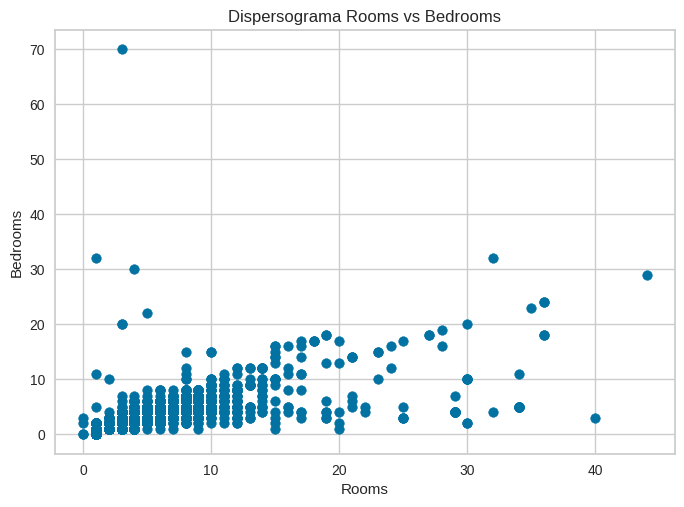

In [ ]:
plt.scatter(reparado['property_rooms'], reparado['property_bedrooms'])
plt.title("Dispersograma Rooms vs Bedrooms")
plt.xlabel("Rooms")
plt.ylabel("Bedrooms")
plt.show()

Podemos notar que existen observacions anómalas, pero no son demasiadas. El valor notoriamente más alejado resulta ser una propiedad, en principio, con más de 70 habitaciones y pocos ambientes. Igualmente, calcularemos la distancia de mahalanobis para cada observación.

In [ ]:
columnas = ["property_rooms", "property_bedrooms"]

In [ ]:
def calculate_mahalanobis_distance(dataset, col1, col2, frac=1):
    X = dataset[[f'{col1}', f'{col2}']].copy()
    sample_X = X.sample(frac=frac)

    mu = sample_X.mean()
    X_diff = X - mu
    X_diff = X_diff.values.T

    cov = np.cov(sample_X.values.T)
    inv_cov = np.linalg.inv(cov)
    W = la.sqrtm(inv_cov)

    Wx = np.matmul(W, X_diff)
    X['mahalanobis'] = [np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])]

    return X

In [ ]:
reparado['mahalanobis'] = calculate_mahalanobis_distance(reparado, 'property_bedrooms', 'property_rooms')['mahalanobis']

<Axes: ylabel='mahalanobis'>

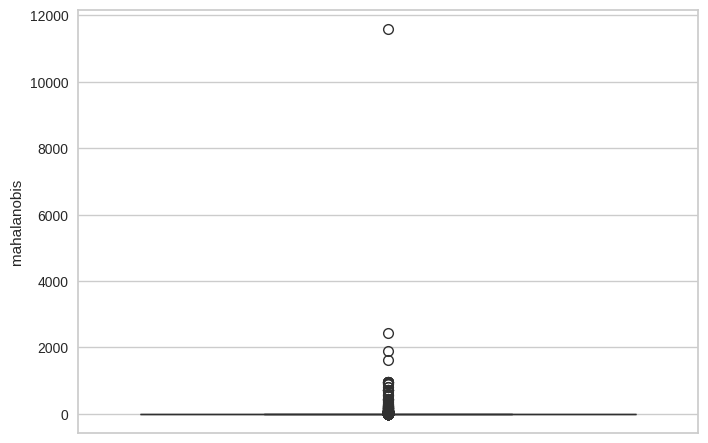

In [ ]:
sns.boxplot(y=reparado.mahalanobis)

In [ ]:
# Cuartiles
Q1 = np.quantile(reparado['mahalanobis'], 0.25)
Q3 = np.quantile(reparado['mahalanobis'], 0.75)

# Rango intercuartil
IQR = Q3 - Q1

# Limite inferior Outliers
out_inf = Q3 - 1.5 * IQR

# Limite superior Outliers
out_sup = Q3 + 1.5 * IQR

out_inf, out_sup

(-0.6874995641090824, 3.4822508384139916)

In [ ]:
umbral = 1100
reparado[reparado["mahalanobis"] > umbral]

,latitud,longitud,city,zone,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,mahalanobis
49960,-34.630186,-58.389156,Capital Federal,Parque Patricios,Venta,Departamento,1.0,32.0,32.000000,32.0,52000.0,Depto 1 ambiente amplio apto profesional,2441.786298
356618,-34.588742,-58.422459,Capital Federal,Palermo,Venta,Departamento,40.0,3.0,75.000000,68.0,145000.0,SOLER 4400 - PALERMO - DPTO 4 AMB C/ BALCON AL...,1627.971880
86014,-34.591110,-58.400685,Capital Federal,Recoleta,Venta,Departamento,4.0,30.0,148.000000,138.0,380000.0,Departamento. Recoleta. Balcón terraza. Silenc...,1884.157845
94998,-34.646632,-58.497902,Capital Federal,Villa Luro,Venta,Departamento,3.0,70.0,82.745773,70.0,135000.0,Departamento - Villa Luro,11594.189741


Nos encontramos con el registro de 70 habitaciones y 3 ambientes que resulta totalmente ilógico, además también de aquellos que tienen más habitaciones que ambientes. El último, en cambio, se trata de un error de tipeo a la hora de cargar el dataset por la descripción de la publicación en la columna title, se trataría de 4 ambientes y no 40. A pesar de que con el boxplot pudimos detectar un solo outliers, analizarlo nos brindó otros.

In [ ]:
umbral_max = 1100
umbral_min = 500
reparado[(reparado["mahalanobis"] > umbral_min) & (reparado['mahalanobis'] < umbral_max)]

,latitud,longitud,city,zone,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,mahalanobis
278256,-34.562512,-58.453917,Capital Federal,Belgrano,Venta,Casa,34.0,5.0,1050.000000,870.000000,3250000.0,Impactante casa estilo INGLÉS - VIRREY DEL PIN...,963.621571
21009,-34.616391,-58.456038,Capital Federal,Caballito,Venta,Departamento,30.0,2.0,79.000000,79.000000,230000.0,C/DEP COCH Y BAULERA - SEGUI AL 700 - Caballito,925.035530
376658,-34.562512,-58.453917,Capital Federal,Belgrano,Venta,Casa,34.0,5.0,1050.000000,870.000000,3250000.0,Impactante casa estilo INGLÉS - VIRREY DEL PIN...,963.621571
137283,-34.579205,-58.398950,Capital Federal,Palermo Chico,Venta,Casa,29.0,4.0,1000.000000,990.000000,4500000.0,VENTA en Palermo Chico Barrio Parque Casa esti...,712.455021
357450,-34.579205,-58.398950,Capital Federal,Palermo Chico,Venta,Casa,29.0,4.0,1000.000000,990.000000,4500000.0,VENTA en Palermo Chico Barrio Parque Casa esti...,712.455021
22023,-34.620757,-58.374913,Capital Federal,San Telmo,Venta,Casa,29.0,7.0,750.000000,750.000000,1500000.0,Casa en venta con 7 dormitorios en San Telmo,531.951621
134312,-34.579205,-58.398950,Capital Federal,Palermo Chico,Venta,Casa,29.0,4.0,1000.000000,990.000000,4500000.0,VENTA en Palermo Chico Barrio Parque Casa esti...,712.455021
168118,-34.606525,-58.430740,Capital Federal,Caballito,Venta,Departamento,44.0,29.0,12.000000,978.535286,23000.0,Departamento - Caballito,649.221578
132367,-34.579205,-58.398950,Capital Federal,Palermo Chico,Venta,Casa,29.0,4.0,1000.000000,990.000000,4500000.0,VENTA en Palermo Chico Barrio Parque Casa esti...,712.455021
368773,-34.562512,-58.453917,Capital Federal,Belgrano,Venta,Casa,34.0,5.0,1050.000000,870.000000,3250000.0,Impactante casa estilo INGLÉS - VIRREY DEL PIN...,963.621571


Algunos valores pueden ser correctos porque existen registros catalogados como departamentos cuando en realidad están vendiendo edificios, otros también tienen un error de tipeo detectado a la hora de comparar con el título del anuncio. En algunos casos podría haber registros con valores correctos.

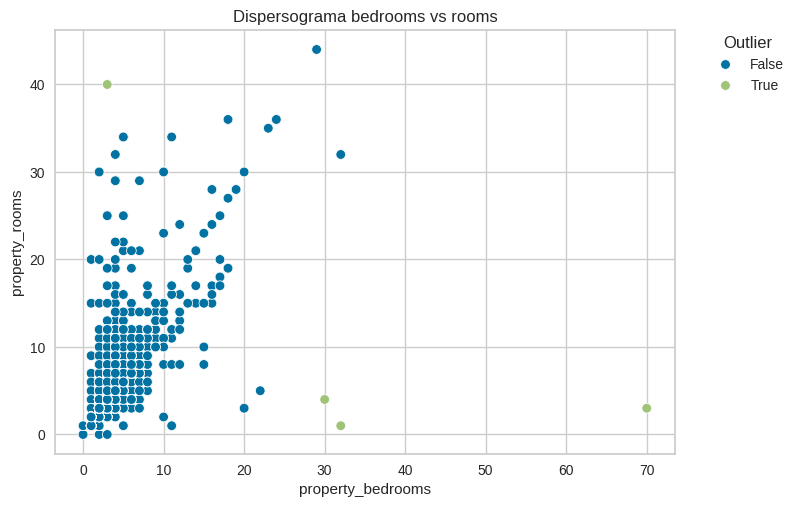

In [ ]:
# Grafico scatter
es_outlier = reparado["mahalanobis"] > umbral

sns.scatterplot(x=reparado['property_bedrooms'], y=reparado['property_rooms'], hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, title="Outlier")
plt.title("Dispersograma bedrooms vs rooms")
plt.show()

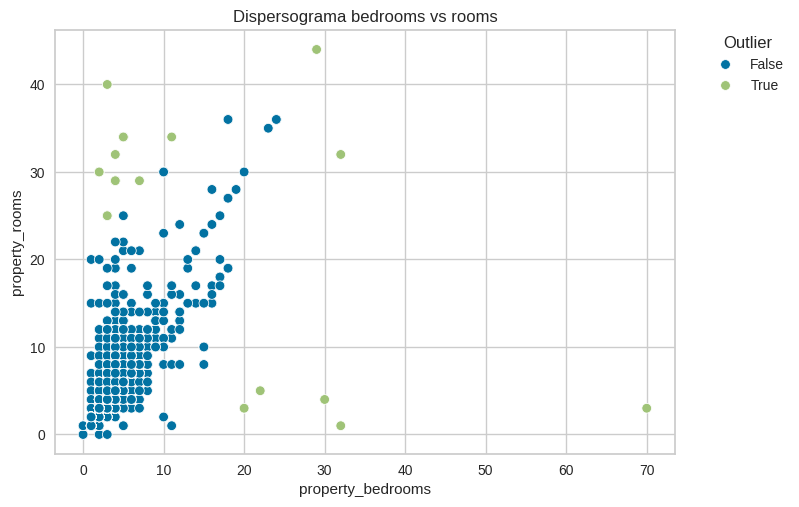

In [ ]:
# Grafico scatter
es_outlier = reparado["mahalanobis"] > umbral_min

sns.scatterplot(x=reparado['property_bedrooms'], y=reparado['property_rooms'], hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, title="Outlier")
plt.title("Dispersograma bedrooms vs rooms")
plt.show()

Gráficamente, tomando un umbral de 1100, podemos ver que se detectan outliers que realmente estan alejados a la nube de puntos. En cambio bajando más el mismo también considera outliers a puntos que están un poco más cerca de los valores que consideramos lógicos, pero que siguen siendo atípicos. Por lo tanto vamos a eliminar aquellos registros cuya distancia sea mayor a 500.

In [ ]:
reparado.drop(reparado[reparado["mahalanobis"] > umbral_min].index, inplace=True)

### Relación entre price vs superfice_total

El trabajo práctico propone también analizar la relación entre precio de venta y los métros de superficie en busca de valores anómalos.

In [ ]:
reparado['mahalanobis'] = calculate_mahalanobis_distance(reparado, 'property_price', 'property_surface_total')['mahalanobis']

<Axes: ylabel='mahalanobis'>

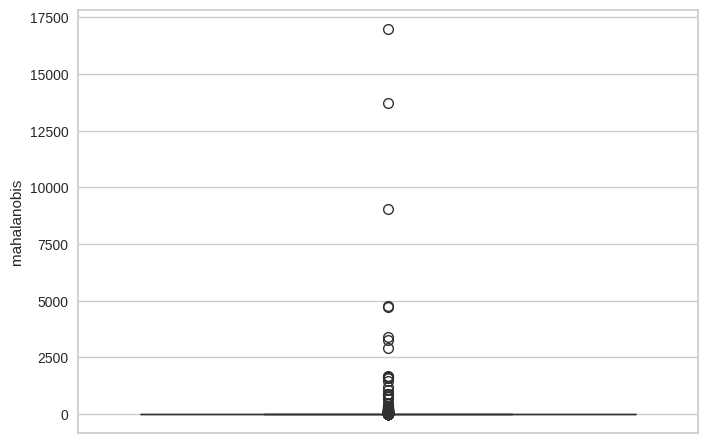

In [ ]:
sns.boxplot(y=reparado.mahalanobis)

Como se puede apreciar, también existen valores anómalos que no detectamos anteriormente. Haremos el mismo trabajo de análisis, definiremos un umbral y veremos, de a partes, cómo son y qué proponemos realizar con estos registros.

In [ ]:
umbral = 1000
reparado[reparado["mahalanobis"] > umbral]

,latitud,longitud,city,zone,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,mahalanobis
370932,-34.571747,-58.422612,Capital Federal,Palermo,Venta,Departamento,4.0,3.0,42110.0,307.0,1691800.0,REVENTA: L'avenue- Departamento de 4 Ambientes...,1594.099325
72521,-34.600113,-58.403649,Capital Federal,Balvanera,Venta,Departamento,2.0,1.0,33800.0,31670.0,66000.0,VENTA 2 AMBIENTES CON RENTA,1033.156479
60073,-34.616044,-58.458621,Capital Federal,Caballito,Venta,Departamento,3.0,2.0,68.0,64.0,21400000.0,Departamento venta,4747.086219
370922,-34.571747,-58.422612,Capital Federal,Palermo,Venta,Departamento,5.0,4.0,42110.0,307.0,2829000.0,Reventa - Departamento - Palermo Nuevo - Liber...,1619.893080
370921,-34.571747,-58.422612,Capital Federal,Palermo,Venta,Departamento,5.0,4.0,42110.0,307.0,2890500.0,Reventa - Departamento - Palermo Nuevo - Liber...,1622.068396
84073,-34.588175,-58.396261,Capital Federal,Recoleta,Venta,Departamento,1.0,1.0,36000.0,30.0,90000.0,Departamento Monoambiente alquiler temporario ...,1171.791520
356064,-31.198907,-60.159719,Capital Federal,Saavedra,Venta,Casa,15.0,2.0,60000.0,350.0,186000.0,VENTA CASA + GALPON + CAMPO EN COLONIA CAMPO D...,3257.137470
370919,-34.571747,-58.422612,Capital Federal,Palermo,Venta,Departamento,5.0,4.0,42110.0,307.0,3044250.0,Reventa - Departamento - Palermo Nuevo - Liber...,1627.857020
72316,-34.578917,-58.429373,Capital Federal,Palermo,Venta,Departamento,2.0,1.0,61130.0,53030.0,225000.0,VENTA DEPARTAMENTO 2 AMBIENTES PALERMO C/AMENI...,3380.016026
129214,-34.599421,-58.386867,Capital Federal,Barrio Norte,Venta,Departamento,5.0,3.0,137000.0,135.0,390000.0,Alquiler Divino 5 Amb. - 137 M² en Barrio Norte,17000.334363


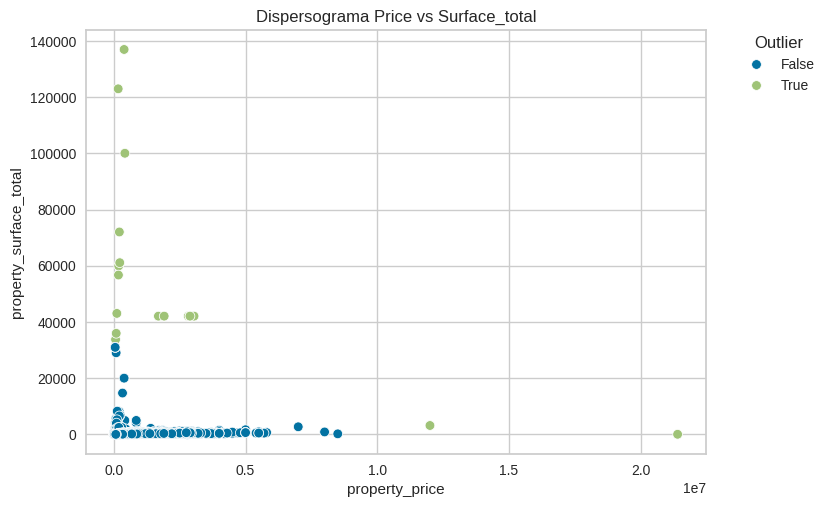

In [ ]:
# Grafico scatter
es_outlier = reparado["mahalanobis"] > 1000

sns.scatterplot(x=reparado['property_price'], y=reparado['property_surface_total'], hue=es_outlier)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, title="Outlier")
plt.title("Dispersograma Price vs Surface_total")
plt.show()

Son registros que difieren mucho con respecto a otros. Pueden tratarse de errores de tipeo o simplemente propiedades que se encuentren en diferentes zonas que influyen en el precio del inmueble a pesar de que tengan la misma superficie. En este caso tomamos la decisión de dejar estos puntos dentro del dataset.

# **2. Agrupamiento**

# a)Analizar la tendencia al clustering del dataset.
Primero instalo la libreria pyclustertend:


In [ ]:
# !pip install pyclustertend

Ahora calculo hopkins:

In [ ]:
# from pyclustertend import hopkins
# hopkins(x,x.shape[0])

# b) Estimar la cantidad apropiada de grupos que se deben formar.

Para este punto usaremos el Elbow Method:

Text(0, 0.5, 'Distancia promedio al centroide')

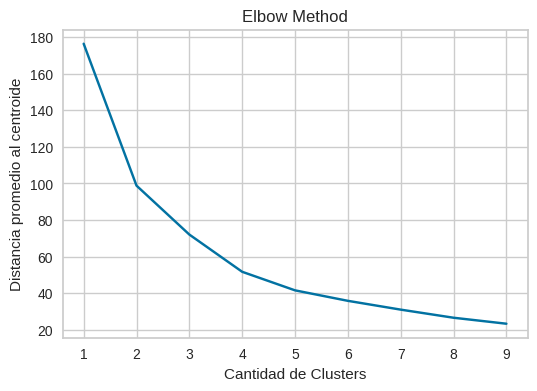

In [ ]:
distancias_prom = []
for i in range(1,10):
  kmeans = KMeans(i)
  kmeans.fit(x_norm)
  iner = kmeans.inertia_
  distancias_prom.append(iner)

cant_clust = range(1,10)
plt.figure(figsize=(6,4))
plt.plot(cant_clust,distancias_prom)
plt.title('Elbow Method')
plt.xlabel('Cantidad de Clusters')
plt.ylabel('Distancia promedio al centroide')

En base al gráfico podemos deducir que utilizar 3 o 4 clusters sería lo ideal:

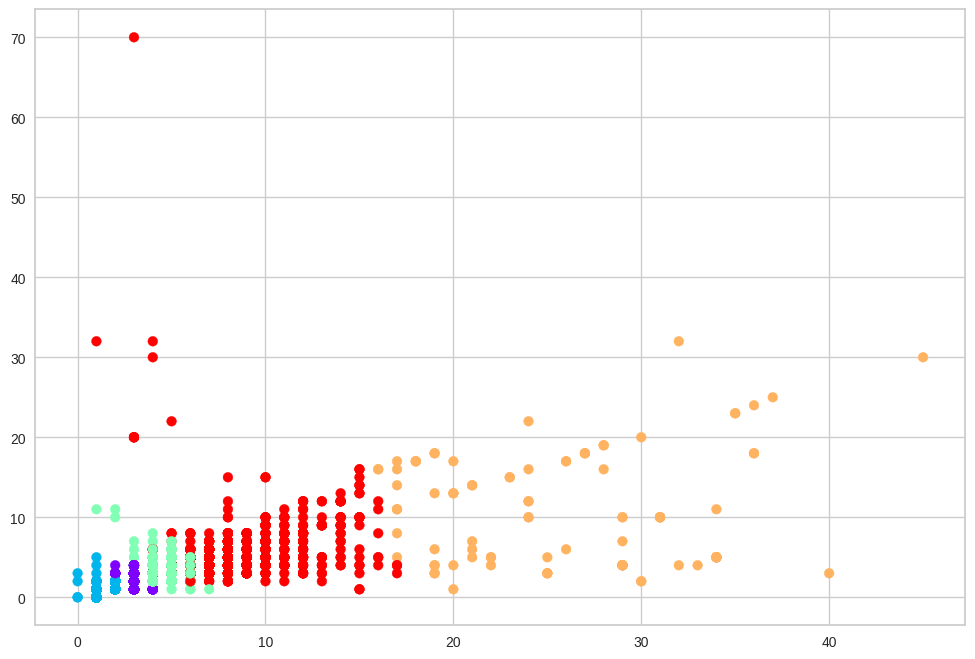

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(x_norm)
identified_clusters = kmeans.fit_predict(x_norm)
data_with_clusters = df_clust.copy()
data_with_clusters['cluster'] = identified_clusters
plt.figure(figsize=(12,8))
plt.scatter(data_with_clusters["property_rooms"], data_with_clusters["property_bedrooms"], c=data_with_clusters["cluster"], cmap='rainbow')
plt.show()

# c) Evaluar la calidad de los grupos formados realizando un análisis de Silhouette.

In [ ]:
from sklearn.metrics import silhouette_score

list_k = list(range(4,10))

for n in list_k:
  clusterer = KMeans(n_clusters=n)
  preds = clusterer.fit_predict(x_norm)

  score = silhouette_score(x_norm,preds)
  print('For n = ' + str(n) + ' silhouette score is ' + str(score))

For n = 4 silhouette score is 0.6014438581843872
For n = 5 silhouette score is 0.6086188762596618
For n = 6 silhouette score is 0.6224717776185817
For n = 7 silhouette score is 0.626605283173453
For n = 8 silhouette score is 0.7188377420256397
For n = 9 silhouette score is 0.7213406279367148


Viendo estos resultados notamos que al haber 7 clusters aumenta el score notablemente:

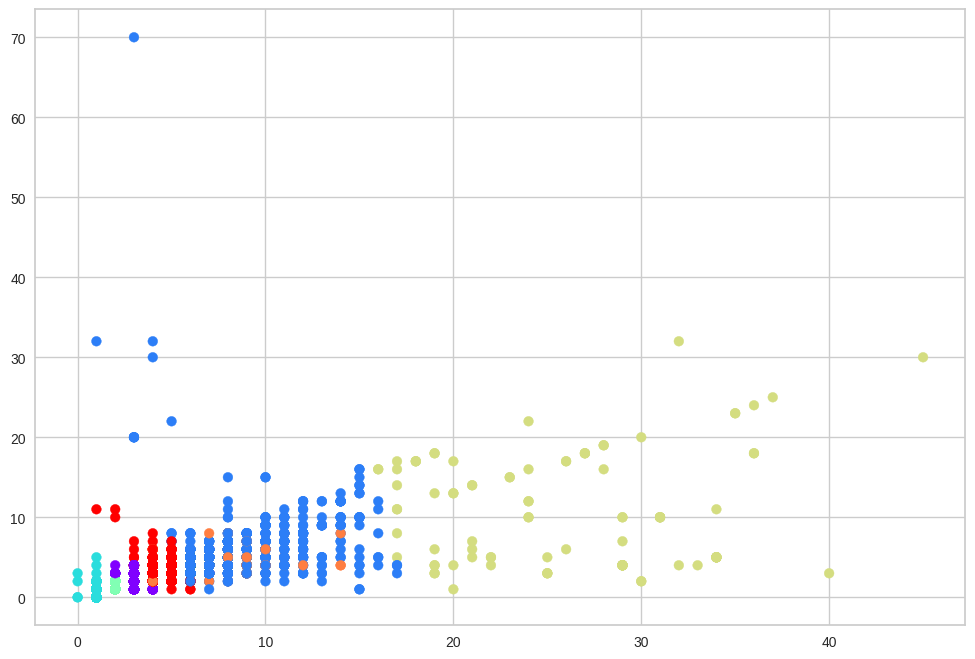

In [ ]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(x_norm)
identified_clusters = kmeans.fit_predict(x_norm)
data_with_clusters = df_clust.copy()
data_with_clusters['cluster'] = identified_clusters
plt.figure(figsize=(12,8))
plt.scatter(data_with_clusters["property_rooms"], data_with_clusters["property_bedrooms"], c=data_with_clusters["cluster"], cmap='rainbow')
plt.show()

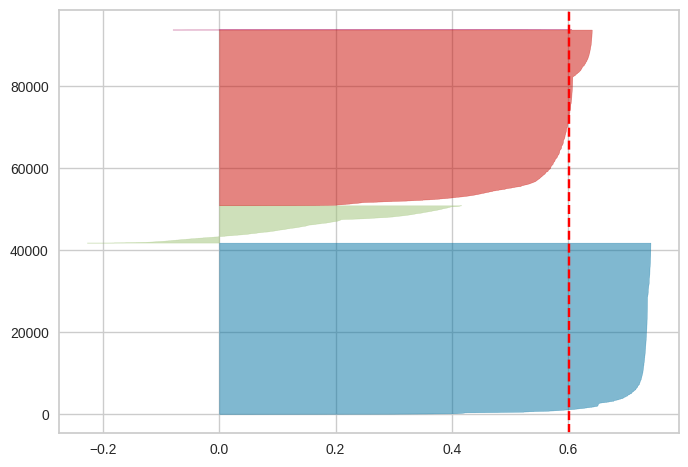

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=4,random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(x_norm)
plt.show()

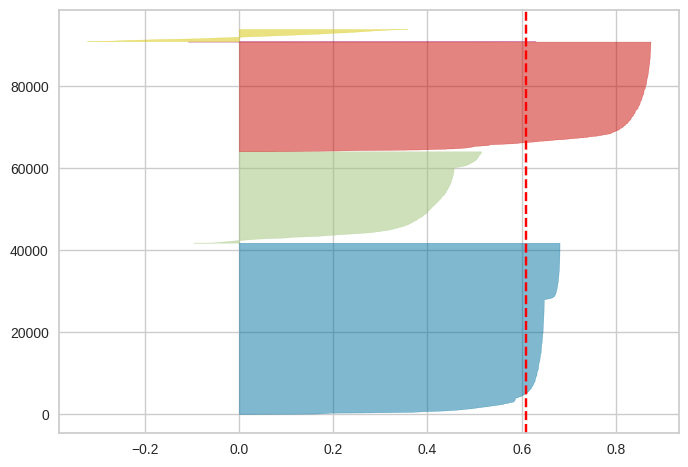

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5,random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(x_norm)
plt.show()

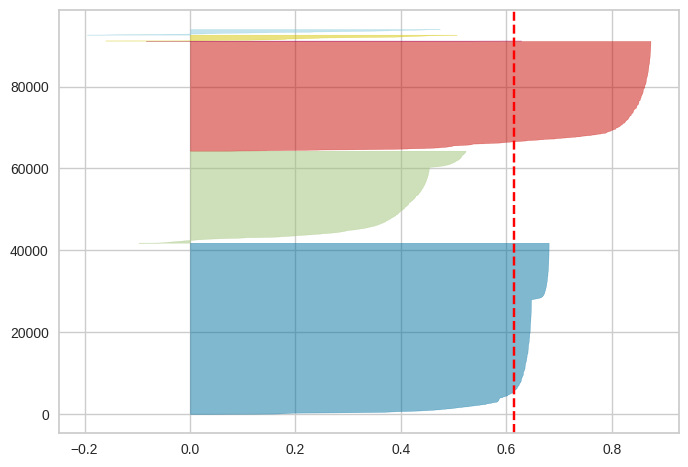

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=6,random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(x_norm)
plt.show()

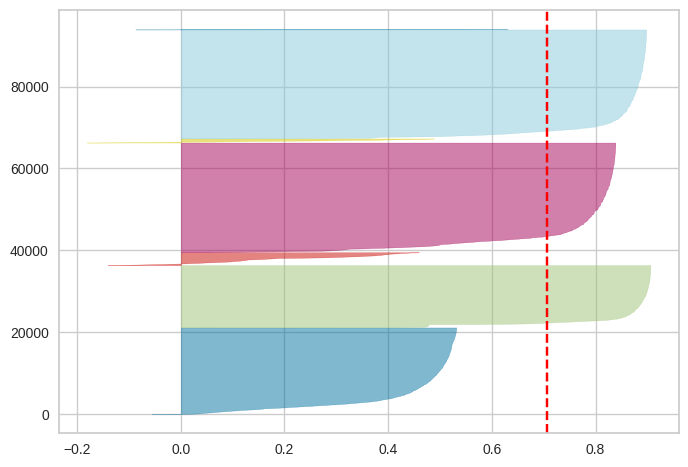

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=7,random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(x_norm)
plt.show()

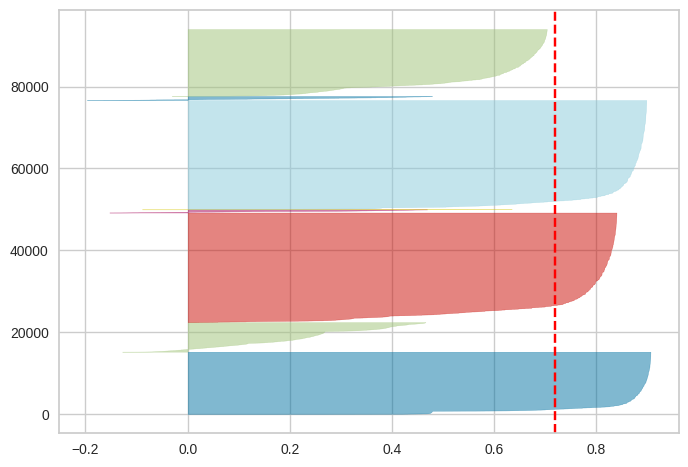

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=8,random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(x_norm)
plt.show()